# Introduction: Hyperparameter Optimization

In this notebook we will explore several options for hyperparameter optimization of a machine learning algorithm. We will start with some of the basic methods such as random search, and then proceed to more sophisticated methods using Guassian Processes.

In [1]:
import hyperopt as hyp
from hyperopt import hp
import btb

from skopt.space import Real, Integer

In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV, KFold

In [3]:
import random

In [4]:
model = lgb.LGBMClassifier(objective = 'binary', n_jobs = -1, boosting_type='goss', colsample_bytree=0.8)

In [5]:
train = pd.read_csv('../input/application_train.csv')
test = pd.read_csv('../input/application_test.csv')
labels = train['TARGET']
features, test_features = pd.get_dummies(train).align(pd.get_dummies(test), axis = 1, join = 'inner')

features = np.array(features)
labels = np.array(labels.astype(np.int32)).reshape((-1,))

# Random Search by Hand

The first method we can implement is simply random search. Each iteration, choose a random set of model hyperparameters from a search space. Empirically, random search is very effective, returning nearly as good results as grid search with a significant reduction in time spent searching. 

Random search can be implement in the Scikit-Learn library with the LightGBM Sklearn API. However, this does not support training with early stopping, which is the most effective method for determining the best number of iterations to use. Therefore, we will implement random search ourselves with a defined parameter grid, and using Early Stopping.

In [6]:
features = features[:10000]
labels = labels[:10000]

In [7]:
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [8]:
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 151)),
    'learning_rate': list(np.logspace(np.log(0.01), np.log(0.2), base = np.exp(1), num = 100)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

subsample_dist = list(np.linspace(0.5, 1, 100))

In [9]:
evals = 5

# Dataframe to hold cv results
results = pd.DataFrame(columns = ['params', 'train_scores', 'train', 'valid_scores', 'valid', 'estimators'],
                       index = list(range(evals)))

In [10]:
# Iterate through the specified number of evaluations
for i in range(evals):
    
    k_fold = KFold(n_splits = 5)
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    # Create the model with the parameters
    model = lgb.LGBMClassifier(class_weight = params['class_weight'], boosting_type = params['boosting_type'], 
                               num_leaves = params['num_leaves'], learning_rate = params['learning_rate'], 
                               subsample_for_bin = params['subsample_for_bin'], min_child_samples = params['min_child_samples'], 
                               reg_alpha = params['reg_alpha'], reg_lambda = params['reg_lambda'], 
                               colsample_by_tree = params['colsample_bytree'], subsample = params['subsample'], 
                               n_estimators = 10000, n_jobs = -1, objective = 'binary')
    
    # Empty lists for records
    valid_scores = []
    train_scores = []
    number_estimators = []
    
    # Split the data
    for (train_indices, valid_indices) in k_fold.split(features):
        
        # Training data and validation set
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Fit the model using early stopping
        model.fit(train_features, train_labels, eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
                  eval_metric = 'auc', eval_names = ['train', 'valid'], early_stopping_rounds = 200, verbose = 200)
        
        
        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        number_estimators.append(model.best_iteration_)
        
    # Average the scores
    valid = np.mean(valid_scores)
    train = np.mean(train_scores)
    estimators = np.mean(number_estimators)
    
    # Add results to next row in dataframe
    results.loc[i, :] = [params, train_scores, train, valid_scores, valid, estimators]

Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.993337	valid's auc: 0.752765
Early stopping, best iteration is:
[23]	train's auc: 0.845289	valid's auc: 0.79571
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.992936	valid's auc: 0.692569
Early stopping, best iteration is:
[95]	train's auc: 0.960178	valid's auc: 0.719902
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.994638	valid's auc: 0.742551
Early stopping, best iteration is:
[26]	train's auc: 0.867585	valid's auc: 0.764146
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.994078	valid's auc: 0.745663
Early stopping, best iteration is:
[41]	train's auc: 0.908086	valid's auc: 0.762621
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.99347	valid's auc: 0.748834
[400]	train's auc: 0.999983	valid's auc: 0.753835
Early stopping, best iteration is:
[278]	train's au

In [11]:
results = results.sort_values('valid', ascending = False)

In [12]:
results.iloc[0, 0]

{'class_weight': None,
 'boosting_type': 'dart',
 'num_leaves': 43,
 'learning_rate': 0.15699877313755697,
 'subsample_for_bin': 160000,
 'min_child_samples': 115,
 'reg_alpha': 0.8571428571428571,
 'reg_lambda': 0.7142857142857142,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 0.7070707070707071}

## Bayesian Hyperparameter Optimization using Hyperopt

In [13]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.stochastic import sample

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

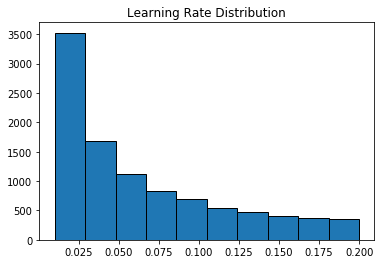

In [15]:
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))}
learning_rate_dist = []

for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.hist(learning_rate_dist, bins = 10, edgecolor = 'k');
plt.title('Learning Rate Distribution');

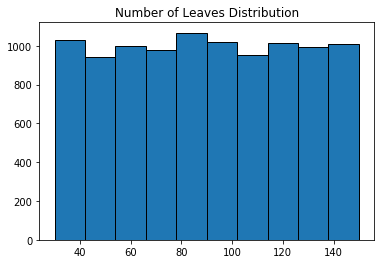

In [16]:
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
plt.hist(num_leaves_dist, bins = 10, edgecolor = 'k');
plt.title('Number of Leaves Distribution');

In [17]:
def objective(params):
    k_fold = KFold(n_splits = 5)
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    model = lgb.LGBMClassifier(n_estimators = 10000, objective = 'binary', n_jobs = -1, **params)
    
    valid_scores = []
    train_scores = []
    number_estimators = []
    
    for (train_indices, valid_indices) in k_fold.split(features):
        
        # Training data and validation set
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Fit the model using early stopping
        model.fit(train_features, train_labels, eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
                  eval_metric = 'auc', eval_names = ['train', 'valid'], early_stopping_rounds = 200, verbose = 200)
    
        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        number_estimators.append(model.best_iteration_)
        
    # fmin needs a loss to minimize
    valid = -1 * np.mean(valid_scores)
    train = -1 * np.mean(train_scores)
    
    # average number of estimators
    estimators = np.mean(number_estimators)
    
    # Dictionary with information for evaluation
    return {'loss': valid, 'train': train, 'estimators': estimators, 'status': STATUS_OK, 'params': params}

In [18]:
# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss'}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [19]:
boosting_type = {'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss'}])}

In [20]:
sample(boosting_type)

{'boosting_type': {'boosting_type': 'goss'}}

In [21]:
sample(boosting_type)

{'boosting_type': {'boosting_type': 'goss'}}

In [22]:
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5))}

In [23]:
sample(learning_rate)

{'learning_rate': 0.02451170847340368}

In [24]:
sample(learning_rate)

{'learning_rate': 0.08261993252407357}

In [25]:
x = sample(space)

### Example of Sampling from the space

After finding the boosting type (which is in a nested dictionary), we assign the boosting type to make it a top level value. We use the dictionary get method to find the 'subsample' if it is in the dictionary (indicating the boosting type is 'gbdt' or 'dart') or set it to 1.0 otherwise (if boosting type is 'goss'). The goss boosting type cannot use bagging. 

This entire step is necessary because of the conditional logic used for the boosting type and subsample ratio.

In addition, we can see the other variables in the dictionary. These will change every time we sample the space.

In [26]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'goss',
 'class_weight': None,
 'colsample_bytree': 0.9272910077296959,
 'learning_rate': 0.012122763100399305,
 'min_child_samples': 95.0,
 'num_leaves': 101.0,
 'reg_alpha': 0.09013896995581105,
 'reg_lambda': 0.25964318128959485,
 'subsample_for_bin': 120000.0,
 'subsample': 1.0}

In [27]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 0.6640817620883687,
 'learning_rate': 0.04227839096249302,
 'min_child_samples': 100.0,
 'num_leaves': 34.0,
 'reg_alpha': 0.4063673530556451,
 'reg_lambda': 0.11436338990065453,
 'subsample_for_bin': 260000.0,
 'subsample': 0.5603141961818652}

## Optimization

In [28]:
trials = Trials()

best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 5, trials = trials, verbose = 1)

Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.994117	valid's auc: 0.784363
Early stopping, best iteration is:
[181]	train's auc: 0.992735	valid's auc: 0.786638
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.993607	valid's auc: 0.714235
Early stopping, best iteration is:
[132]	train's auc: 0.989305	valid's auc: 0.720439
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.99331	valid's auc: 0.748526
Early stopping, best iteration is:
[144]	train's auc: 0.990143	valid's auc: 0.752484
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.993036	valid's auc: 0.742581
[400]	train's auc: 0.999149	valid's auc: 0.749585
[600]	train's auc: 0.999947	valid's auc: 0.749068
[800]	train's auc: 1	valid's auc: 0.749103
Early stopping, best iteration is:
[622]	train's auc: 0.999963	valid's auc: 0.752483
Training until validation scores don't improve for 200 rounds.
[20

In [29]:
trials.results

[{'loss': -0.7553202304736557,
  'train': -0.9933596538632701,
  'estimators': 260.2,
  'status': 'ok',
  'params': {'boosting_type': 'dart',
   'class_weight': 'balanced',
   'colsample_bytree': 0.7325194811298903,
   'learning_rate': 0.0322394020403845,
   'min_child_samples': 35,
   'num_leaves': 133,
   'reg_alpha': 0.6040341766472112,
   'reg_lambda': 0.9749800011842601,
   'subsample_for_bin': 60000,
   'subsample': 0.7393108733309419}},
 {'loss': -0.752628643339592,
  'train': -0.851750090849617,
  'estimators': 49.4,
  'status': 'ok',
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.9792154501227568,
   'learning_rate': 0.1989637872681772,
   'min_child_samples': 400,
   'num_leaves': 36,
   'reg_alpha': 0.9504607597248819,
   'reg_lambda': 0.015694998918869718,
   'subsample_for_bin': 40000,
   'subsample': 0.5927705664585545}},
 {'loss': -0.7502765057979331,
  'train': -0.9478254132302046,
  'estimators': 75.0,
  'status': 'ok',
  

In [32]:
trials_results = sorted(trials.results, key = lambda x: x['loss'])

In [33]:
trials_results[:2]

[{'loss': -0.7631596069346753,
  'train': -0.8700047665028695,
  'estimators': 317.6,
  'status': 'ok',
  'params': {'boosting_type': 'goss',
   'class_weight': None,
   'colsample_bytree': 0.9259224457587562,
   'learning_rate': 0.022152509734637536,
   'min_child_samples': 150,
   'num_leaves': 61,
   'reg_alpha': 0.91623559266011,
   'reg_lambda': 0.12139739021315099,
   'subsample_for_bin': 160000,
   'subsample': 1.0}},
 {'loss': -0.756279342144564,
  'train': -0.8461713716946424,
  'estimators': 82.4,
  'status': 'ok',
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.7619713496234854,
   'learning_rate': 0.06898450281007874,
   'min_child_samples': 370,
   'num_leaves': 134,
   'reg_alpha': 0.06031708326095664,
   'reg_lambda': 0.6296580469258597,
   'subsample_for_bin': 300000,
   'subsample': 0.5360875019436323}}]